### **Test: Count Frequency of Each Operators**

In [87]:
import pathlib
import os
from collections import defaultdict, Counter
import re
from tqdm import tqdm

import pandas as pd
from sqlglot import parse, errors as sg_errors, expressions as exp
from sqlglot import expressions as exp

In [66]:
base_dir = pathlib.Path(os.getcwd()).parent

query_dirs = {
    "calcite": base_dir / "calcite" / "query",
    "github-repos": base_dir / "github-repos" / "query",
    "job": base_dir / "job" / "postgres",
    "job-light": base_dir / "job-light" / "query",
    "stats": base_dir / "stats" / "postgres",
    "tpch": base_dir / "tpch" / "postgres",
    "test": base_dir / "test" / "query"
}

In [92]:
AGG_CLASSES = (
    exp.Count, exp.Sum, exp.Min, exp.Max, # 나머지 agg function은 QED에서 지원 안함
)

In [93]:
def is_agg_fn(node: exp.Expression) -> bool:
    return isinstance(node, AGG_CLASSES) or bool(getattr(node, "is_aggregate", False))

In [94]:
def _join_side(n, side: str) -> bool:
    return isinstance(n, exp.Join) and str(n.args.get("side", "")).upper() == side

def _join_kind(n, kind: str) -> bool:
    return isinstance(n, exp.Join) and str(n.args.get("kind", "")).upper() == kind

In [95]:
OP_CHECKS = {
    "TableScan"  : lambda n: isinstance(n, exp.Table),
    "Filter"     : lambda n: isinstance(n, exp.Where),
    "Projection" : lambda n: isinstance(n, exp.Select),
    "Distinct"   : lambda n: isinstance(n, exp.Select) and n.args.get("distinct"),
    "SubQuery"   : lambda n: isinstance(n, exp.Subquery),

    # ─── JOIN 구분 ───
    "Inner Join" : lambda n: _join_kind(n, "INNER") or (_join_kind(n, "") and n.args.get("side") is None),
    "Left Join"  : lambda n: _join_side(n, "LEFT"),
    "Right Join" : lambda n: _join_side(n, "RIGHT"),
    "Outer Join" : lambda n: _join_side(n, "FULL") or _join_side(n, "OUTER") or _join_side(n, "FULL OUTER"),

    "Group By"   : lambda n: isinstance(n, exp.Group),
    "Exists"     : lambda n: isinstance(n, exp.Exists),
    "Union"      : lambda n: isinstance(n, exp.Union),
    "Minus"      : lambda n: isinstance(n, exp.Except),
    "Intersect"  : lambda n: isinstance(n, exp.Intersect),
    "Aggregate"  : is_agg_fn,          # ← 변경된 판별 로직
    "Sort"       : lambda n: isinstance(n, exp.Order),
    "Limit"      : lambda n: isinstance(n, exp.Limit),
    "Offset"     : lambda n: isinstance(n, exp.Offset),
}

ALL_OPS = list(OP_CHECKS)

In [96]:
def sanitize_sql(sql: str) -> str:
    """
    흔히 발견되는 비표준 구문을 최소한으로 교정.
    (VALUES) → (VALUES (NULL))  같은 한 줄짜리 패치만 수행.
    """
    return re.sub(
        r"\(\s*VALUES\s*\)", "(VALUES (NULL))", sql, flags=re.IGNORECASE | re.MULTILINE
    )

In [97]:
def count_ops_in_sql(sql_text: str) -> Counter:
    counts = Counter()
    sql_text = sanitize_sql(sql_text)

    try:
        trees = parse(sql_text, dialect="postgres", error_level="ignore")
    except sg_errors.ParseError:
        # 완전히 파싱할 수 없는 경우엔 그냥 건너뜀
        return counts

    for tree in trees:
        if not tree:            # error_level="ignore" 인 경우 None 가능
            continue
        for node in tree.walk():
            for op, pred in OP_CHECKS.items():
                if pred(node):
                    counts[op] += 1
    return counts

In [136]:
total_query_count = sum(len(list(qdir.rglob("*.sql"))) for qdir in query_dirs.values())
print(f"Total query count: {total_query_count}")

Total query count: 9413


In [137]:
bench_op_counts = defaultdict(Counter)

for bench, qdir in query_dirs.items():
    print(f"Processing {bench} queries in {qdir}...")
    err_list = []
    for sql_file in tqdm(qdir.rglob("*.sql")):
        sql = sql_file.read_text(encoding="utf-8", errors="ignore")
        try:
            bench_op_counts[bench] += count_ops_in_sql(sql)
        except Exception as e:
            err_list.append(f"-- Error processing {sql_file}: {e}")
            continue

    if err_list:
        print("\n".join(err_list))
    print(f"Finished processing {bench} queries.\n")

Processing calcite queries in /Users/hoeun/Desktop/Projects/sql-benchmark/calcite/query...


464it [00:00, 1389.77it/s]


Finished processing calcite queries.

Processing github-repos queries in /Users/hoeun/Desktop/Projects/sql-benchmark/github-repos/query...


8574it [00:06, 1298.42it/s]


-- Error processing /Users/hoeun/Desktop/Projects/sql-benchmark/github-repos/query/discourse_5190.sql: Error tokenizing ' ORDER BY posts.created_at DESC LIMIT 9 OFFSET 0'
Finished processing github-repos queries.

Processing job queries in /Users/hoeun/Desktop/Projects/sql-benchmark/job/postgres...


137it [00:00, 549.26it/s]


Finished processing job queries.

Processing job-light queries in /Users/hoeun/Desktop/Projects/sql-benchmark/job-light/query...


70it [00:00, 1483.61it/s]


Finished processing job-light queries.

Processing stats queries in /Users/hoeun/Desktop/Projects/sql-benchmark/stats/postgres...


146it [00:00, 1027.37it/s]


Finished processing stats queries.

Processing tpch queries in /Users/hoeun/Desktop/Projects/sql-benchmark/tpch/postgres...


22it [00:00, 859.67it/s]

Finished processing tpch queries.



In [104]:
df = (
    pd.DataFrame.from_dict(bench_op_counts, orient="index")
      .reindex(columns=ALL_OPS)               # 열 순서 고정
      .fillna(0)
      .astype(int)
)
df.index.name = "benchmark"

In [114]:
df_with_sum = df.copy()
df_with_sum.loc['sum'] = df.sum()

In [115]:
df_with_sum

,TableScan,Filter,Projection,Distinct,SubQuery,Inner Join,Left Join,Right Join,Outer Join,Group By,Exists,Union,Minus,Intersect,Aggregate,Sort,Limit,Offset
benchmark,,,,,,,,,,,,,,,,,,
calcite,776,343,945,0,349,135,44,23,10,260,8,100,22,13,361,36,6,6
github-repos,8221,4329,9498,579,617,1102,1649,0,0,96,65,259,0,0,2147,1387,1356,236
job,1115,137,137,0,0,978,0,0,0,2,0,0,0,0,344,2,0,0
job-light,254,70,70,0,0,184,0,0,0,0,0,0,0,0,70,0,0,0
stats,632,146,146,0,0,486,0,0,0,0,0,0,0,0,146,0,0,0
tpch,90,33,42,0,15,52,1,0,0,20,4,0,0,0,35,18,21,0
sum,11088,5058,10838,579,981,2937,1694,23,10,378,77,359,22,13,3103,1443,1383,242


In [116]:
df_with_sum.to_csv(base_dir / "query_op_counts.csv", encoding="utf-8")

### **Parsed Test Queries**

In [107]:
import pathlib, os, re, textwrap
import sqlglot
from tqdm import tqdm
from sqlglot import errors as sg_errors

In [108]:
base_dir = pathlib.Path(os.getcwd()).parent
test_dir  = base_dir / "test" / "query"

In [109]:
def sanitize_sql(sql: str) -> str:
    """
    간단한 문법 오류(VALUES () 등)를 최소한으로 교정.
    필요하면 여기서 추가적으로 패치.
    """
    return re.sub(r"\(\s*VALUES\s*\)", "(VALUES (NULL))", sql,
                  flags=re.IGNORECASE | re.MULTILINE)

In [110]:
for sql_path in tqdm(sorted(test_dir.rglob("*.sql"))):
    print(f"\n=== {sql_path.relative_to(base_dir)} ===")
    raw_sql = sql_path.read_text("utf-8", "ignore")
    sql_txt = sanitize_sql(raw_sql)

    try:
        trees = sqlglot.parse(sql_txt, dialect="postgres")
    except sg_errors.ParseError as e:
        print(f"[ParseError] {e}")
        continue

    # 여러 문(statement)이 있을 수 있음
    for idx, tree in enumerate(trees, start=1):
        if tree is None:        # error_level="ignore" 사용 시 None 가능
            print(f"[{idx}] <parse skipped>")
            continue

        # 1) 깔끔한 트리 뷰
        print(f"[{idx}] AST:")
        print(textwrap.indent(tree.to_s(), "    "))

        # 2) 파싱된 SQL(표준화) 확인이 필요하면 주석 해제
        print(f"[{idx}] Normalized SQL:\n{textwrap.indent(tree.sql(pretty=True), '    ')}")

100%|██████████| 9/9 [00:00<00:00, 705.70it/s]


=== test/query/aggr_1.sql ===
[1] AST:
    Select(
      kind=None,
      hint=None,
      distinct=None,
      expressions=[
        Alias(
          this=Count(
            this=Star(except=None, replace=None, rename=None, _type=None, _comments=None, _id=5105148640),
            expressions=[],
            big_int=True,
            _type=None,
            _comments=[],
            _id=5105153008),
          alias=Identifier(this=total_orders, quoted=False, _type=None, _comments=None, _id=5105144048),
          _type=None,
          _comments=None,
          _id=5105149088)],
      limit=None,
      operation_modifiers=None,
      from=From(
        this=Table(
          this=Identifier(this=orders, quoted=False, _type=None, _comments=None, _id=5102021312),
          db=None,
          catalog=None,
          _type=None,
          _comments=None,
          _id=5102018848),
        _type=None,
        _comments=None,
        _id=5102012240),
      _type=None,
      _comments=[],
     

### **Visualize to Graph**

In [123]:
import numpy as np
import matplotlib.pyplot as plt

In [124]:
df = pd.read_csv(base_dir / "query_op_counts.csv", index_col="benchmark")

In [125]:
df

,TableScan,Filter,Projection,Distinct,SubQuery,Inner Join,Left Join,Right Join,Outer Join,Group By,Exists,Union,Minus,Intersect,Aggregate,Sort,Limit,Offset
benchmark,,,,,,,,,,,,,,,,,,
calcite,776,343,945,0,349,135,44,23,10,260,8,100,22,13,361,36,6,6
github-repos,8221,4329,9498,579,617,1102,1649,0,0,96,65,259,0,0,2147,1387,1356,236
job,1115,137,137,0,0,978,0,0,0,2,0,0,0,0,344,2,0,0
job-light,254,70,70,0,0,184,0,0,0,0,0,0,0,0,70,0,0,0
stats,632,146,146,0,0,486,0,0,0,0,0,0,0,0,146,0,0,0
tpch,90,33,42,0,15,52,1,0,0,20,4,0,0,0,35,18,21,0
sum,11088,5058,10838,579,981,2937,1694,23,10,378,77,359,22,13,3103,1443,1383,242


In [129]:
operators = df.columns
benchmarks = df.index[:-1]  # 마지막 행은 합계이므로 제외
x = np.arange(len(operators))
bar_w = 0.8 / len(benchmarks)

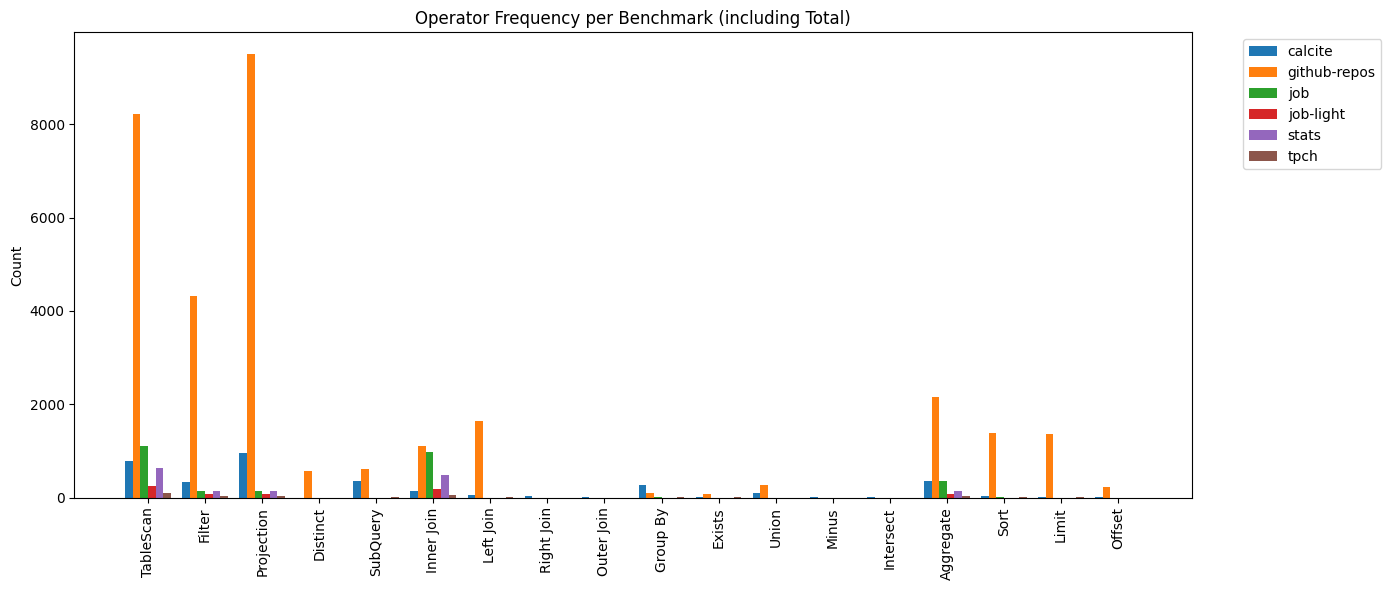

In [130]:
plt.figure(figsize=(14, 6))

for i, bench in enumerate(benchmarks):
    plt.bar(
        x + i * bar_w,
        df.loc[bench],
        width=bar_w,
        label=bench,
    )
    
plt.xticks(x + bar_w * (len(benchmarks) - 1) / 2, operators, rotation=90)
plt.ylabel("Count")
plt.title("Operator Frequency per Benchmark (including Total)")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [135]:
df_with_sum_ratio = df_with_sum.copy()
df_with_sum_ratio.loc['sum_ratio'] = df_with_sum_ratio.loc['sum'] / 29140
df_with_sum_ratio.loc['sum_ratio', 'TableScan'] = 0
df_with_sum_ratio

,TableScan,Filter,Projection,Distinct,SubQuery,Inner Join,Left Join,Right Join,Outer Join,Group By,Exists,Union,Minus,Intersect,Aggregate,Sort,Limit,Offset
benchmark,,,,,,,,,,,,,,,,,,
calcite,776.0,343.000000,945.000000,0.00000,349.000000,135.000000,44.000000,23.000000,10.000000,260.000000,8.000000,100.00000,22.000000,13.000000,361.000000,36.00000,6.000000,6.000000
github-repos,8221.0,4329.000000,9498.000000,579.00000,617.000000,1102.000000,1649.000000,0.000000,0.000000,96.000000,65.000000,259.00000,0.000000,0.000000,2147.000000,1387.00000,1356.000000,236.000000
job,1115.0,137.000000,137.000000,0.00000,0.000000,978.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.00000,0.000000,0.000000,344.000000,2.00000,0.000000,0.000000
job-light,254.0,70.000000,70.000000,0.00000,0.000000,184.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,70.000000,0.00000,0.000000,0.000000
stats,632.0,146.000000,146.000000,0.00000,0.000000,486.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,146.000000,0.00000,0.000000,0.000000
tpch,90.0,33.000000,42.000000,0.00000,15.000000,52.000000,1.000000,0.000000,0.000000,20.000000,4.000000,0.00000,0.000000,0.000000,35.000000,18.00000,21.000000,0.000000
sum,11088.0,5058.000000,10838.000000,579.00000,981.000000,2937.000000,1694.000000,23.000000,10.000000,378.000000,77.000000,359.00000,22.000000,13.000000,3103.000000,1443.00000,1383.000000,242.000000
sum_ratio,0.0,0.173576,0.371929,0.01987,0.033665,0.100789,0.058133,0.000789,0.000343,0.012972,0.002642,0.01232,0.000755,0.000446,0.106486,0.04952,0.047461,0.008305
